In [47]:
import torch
import os
import pickle
from pytorch3d.ops import knn_points, knn_gather
import os.path as osp
import matplotlib.pyplot as plt
from glob import glob

## Visualize all the network inputs and outputs

### Get the input

In [59]:
output_root = '/home/shimingwang/workspace/sf_tv/sceneflow_tv_se/outputs'
output_folder =  'sf_voxel_model_seflowloss_new_volconv/25e5c600-36fe-3245-9cc0-40ef91620c22'

output_path = osp.join(output_root, output_folder)
print(output_path)
print
file_list = []
for file_name in glob(f'{output_path}/*.pkl'):
    file_list.append(file_name)

print(len(file_list))

/home/shimingwang/workspace/sf_tv/sceneflow_tv_se/outputs/sf_voxel_model_seflowloss_new_volconv/25e5c600-36fe-3245-9cc0-40ef91620c22
156


In [60]:
index = 125 
file_path = file_list[index]
print(file_path)

file_name = file_path.split('/')[-1]
print(file_name)

with open(file_path, 'rb') as f:
    outputs = pickle.load(f)

print(outputs.keys())   

/home/shimingwang/workspace/sf_tv/sceneflow_tv_se/outputs/sf_voxel_model_seflowloss_new_volconv/25e5c600-36fe-3245-9cc0-40ef91620c22/315966116260259000.pkl
315966116260259000.pkl


dict_keys(['input_batch', 'model_output', 'final_flow'])


In [61]:
input_batch = outputs['input_batch']
print(input_batch.keys())

model_output = outputs['model_output'] 
print(model_output.keys())

voting_vol = model_output['voting_vol']

print(voting_vol.shape)

dict_keys(['scene_id', 'timestamp', 'pc0', 'gm0', 'pose0', 'pc1', 'gm1', 'pose1', 'flow', 'flow_is_valid', 'flow_category_indices', 'ego_motion', 'origin_pc0'])
dict_keys(['pseudoimages_src', 'pseudoimages_dst', 'pseudoimages_grid', 'feats_voxel_src', 'feats_voxel_dst', 'voxels_src', 'voting_vol', 'points_src_offset', 'points_src_voxel_idx', 'flow', 'pc0_points_lst', 'pc1_points_lst', 'pc0_valid_point_idxes', 'pc1_valid_point_idxes', 'pose_flow'])
torch.Size([11137, 20, 20])


In [62]:
print('pc0:', input_batch['pc0'].shape)
print('pc1:', input_batch['pc1'].shape)
print('gt_flow:', input_batch['flow'].shape)  
print('voting vol:', model_output['voting_vol'].shape)
print('points_src_voxel:', model_output['points_src_voxel_idx'].shape)
print('pc0_valid_pst_idx:', model_output['pc0_valid_point_idxes'].shape)
print('pc0_points_lst:', model_output['pc0_points_lst'].shape)
print('points_src_offsets:', model_output['points_src_offset'].shape)

print(model_output['pc0_valid_point_idxes'][:10], model_output['pc0_valid_point_idxes'].max())
print(model_output['points_src_voxel_idx'][:10], model_output['points_src_voxel_idx'].max())

pc0: torch.Size([69962, 3])
pc1: torch.Size([69784, 3])
gt_flow: torch.Size([95455, 3])
voting vol: torch.Size([11137, 20, 20])
points_src_voxel: torch.Size([42692])
pc0_valid_pst_idx: torch.Size([42692])
pc0_points_lst: torch.Size([42692, 3])
points_src_offsets: torch.Size([42692, 3])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0') tensor(69961, device='cuda:0')
tensor([9618, 9104, 9104, 9647, 9674, 9130, 9118, 9704, 9704, 9147],
       device='cuda:0') tensor(11136, device='cuda:0')


In [63]:
points_src_offsets = model_output['points_src_offset']
points_src_voxel = model_output['points_src_voxel_idx']

print(points_src_offsets.shape)
print(points_src_offsets[:42686,:])

print(points_src_voxel.shape)
print(points_src_voxel[42684:43084])

torch.Size([42692, 3])
tensor([[ 0.0876, -0.0379,  0.5870],
        [-0.0824, -0.0483, -2.5300],
        [-0.0355, -0.0478, -1.5164],
        ...,
        [-0.0403,  0.0919,  1.4510],
        [-0.0856, -0.0995,  0.4316],
        [ 0.0300,  0.0240, -0.4801]], device='cuda:0')
torch.Size([42692])
tensor([ 931, 2773,  768,  860,  891, 2773,  727,  929], device='cuda:0')


In [64]:
flow = input_batch['flow']

flow = flow[model_output['pc0_valid_point_idxes']]
pose_flow = model_output['pose_flow'][model_output['pc0_valid_point_idxes']]
print(flow.shape)
print(pose_flow.shape)  


gt_flow = flow - pose_flow

torch.Size([42692, 3])
torch.Size([42692, 3])


### Visualize the point clouds

In [65]:
import numpy as np

In [115]:
%matplotlib inline
def visual_pc(pc,
              eval_range=54):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
    ax.set_facecolor('white')
    ax.tick_params(left = False,
                right = False ,
                labelleft = False ,
                labelbottom = False,
                bottom = False)

    dists = np.sqrt(np.sum(pc[:, :2] ** 2, axis=1))
    # colors = np.minimum(1, dists / eval_range)
    ax.scatter(pc[ :,0], pc[ :,1], c='black', s=0.2)
    l =[10109]
    
    ax.scatter(pc[l, 0], pc[l, 1], c='red', s=20)
    print(pc[l])
    print(pc[l].shape)
    # Show ego vehicle.
    ax.plot(0, 0, 'x', color='black')
    ax.grid(True)
    ax.axis(True)
    axes_limit = eval_range  # Slightly bigger to include boxes that extend beyond the range.
    ax.set_xlim(-axes_limit, axes_limit)
    ax.set_ylim(-axes_limit, axes_limit)
    
    plt.show()

In [145]:
%matplotlib inline
def visual_pc_3d(pc,
              eval_range=54):
    # fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True, projection='3d')
    
    fig = plt.figure(figsize=(8, 8), tight_layout=True,)
    ax = fig.add_subplot(projection='3d')
    ax.set_facecolor('white')
    ax.tick_params(left = False,
                right = False ,
                labelleft = False ,
                labelbottom = False,
                bottom = False)

    dists = np.sqrt(np.sum(pc[:, :2] ** 2, axis=1))
    colors = np.minimum(1, dists / eval_range)
    # ax.scatter(pc[ :,0], pc[ :,1], pc[:,2], c=colors, cmap='viridis')
    l =np.array([10109])
    ax.scatter(pc[l, 0], pc[l, 1], pc[l,2], c='red', s=50)
    print(pc[l])
    
    p_mask_x = np.logical_and(pc[:, 0] < -2.6301000e-01+0.2, pc[:, 0] >-2.6301000e-01+0.2-0.2)
    p_mask_y = np.logical_and(pc[:, 1] < 2.2342329e+01+0.2, pc[:, 1] >2.2342329e+01+0.2-0.2)

    p_mask = np.logical_and(p_mask_x, p_mask_y)
    
    pc = pc[p_mask]
    ax.scatter(pc[:,0], pc[:,1], pc[:,2], c='black', alpha=0.1, s=10)

    
    

    # Show ego vehicle.
    ax.plot(0, 0, 'x', color='black')
    axes_limit = eval_range  # Slightly bigger to include boxes that extend beyond the range.
    ax.set_xlim(-axes_limit, axes_limit)
    ax.set_ylim(-axes_limit, axes_limit)
    
    plt.show()

In [86]:
pc_src = input_batch['pc0']
ego_flow = model_output['pose_flow']

pc_src_emc = pc_src + ego_flow

valid_pc = model_output['pc0_points_lst']

print(pc_src_emc.shape)
print(valid_pc.shape)

torch.Size([69962, 3])
torch.Size([42692, 3])


[[-2.6301000e-01  2.2342329e+01 -1.6872588e-03]]
(1, 3)


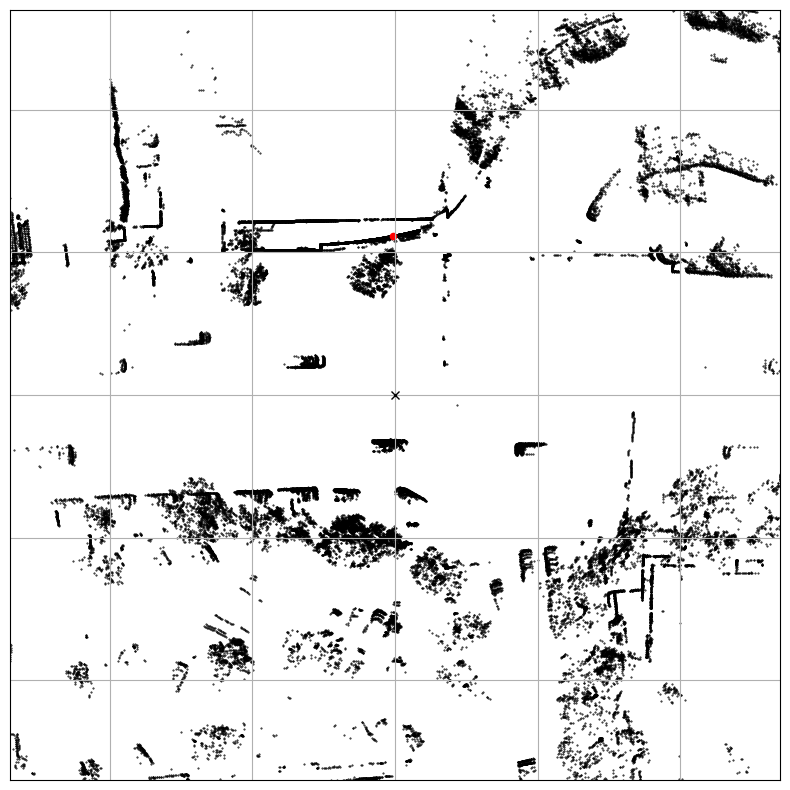

In [116]:
visual_pc(pc_src_emc.cpu().numpy())

[[-2.6301000e-01  2.2342329e+01 -1.6872588e-03]]


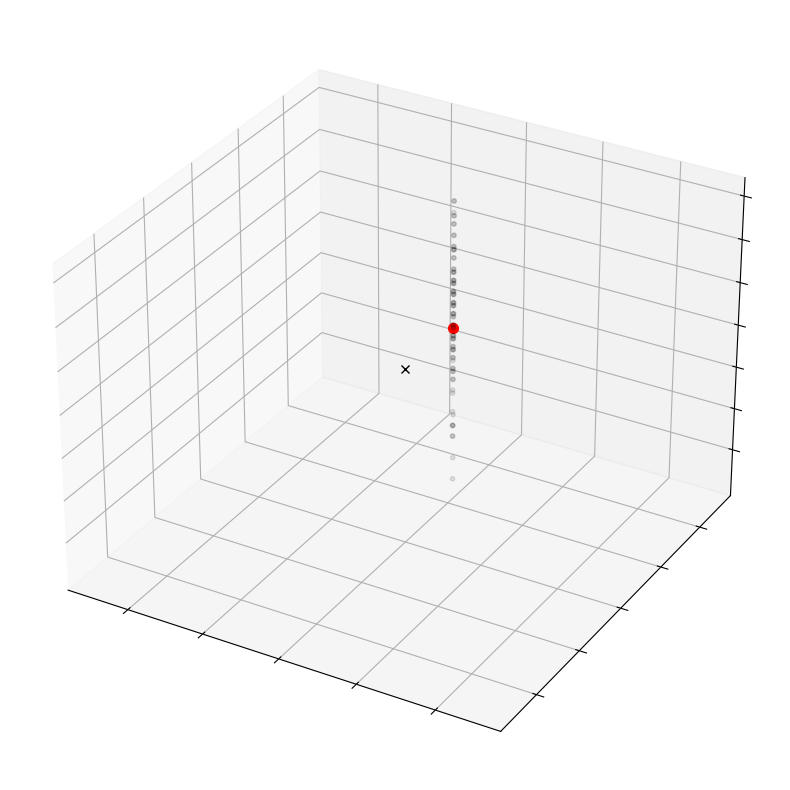

In [144]:
visual_pc_3d(pc_src_emc.cpu().numpy())

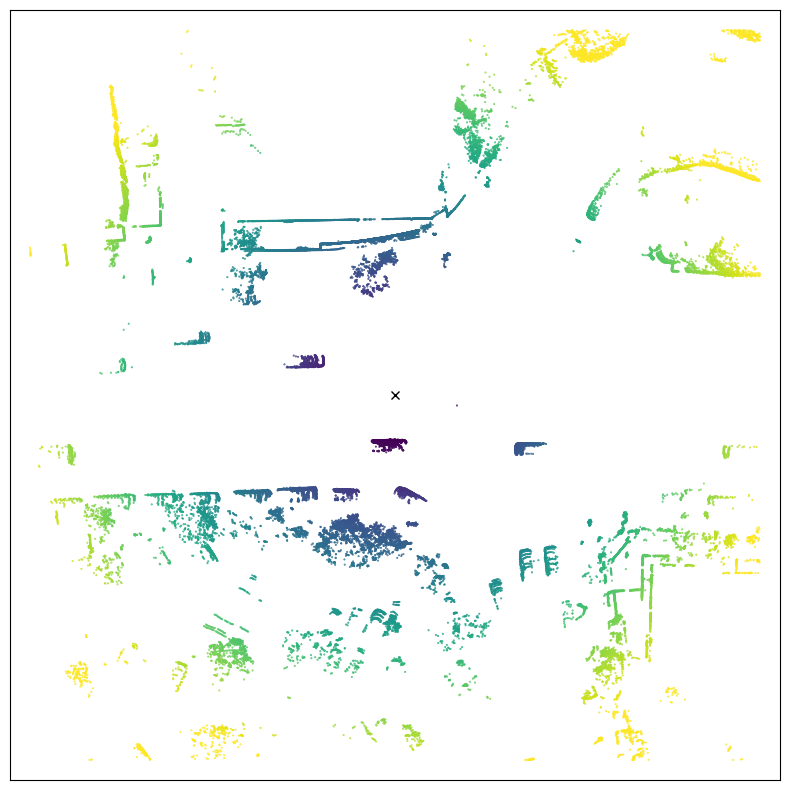

In [69]:
visual_pc(valid_pc.cpu().numpy())

## Visualize the gird features

In [17]:
pseudo_img_src = model_output['pseudoimages_src']
print(pseudo_img_src.shape)
pseudo_img_dst = model_output['pseudoimages_dst']
print(pseudo_img_dst.shape)
pseudo_img_grid  = model_output['pseudoimages_grid']
print(pseudo_img_grid.shape)


torch.Size([32, 512, 512])
torch.Size([32, 512, 512])
torch.Size([64, 512, 512])


torch.Size([512, 512])
tensor(1.3544, device='cuda:0') tensor(0., device='cuda:0')


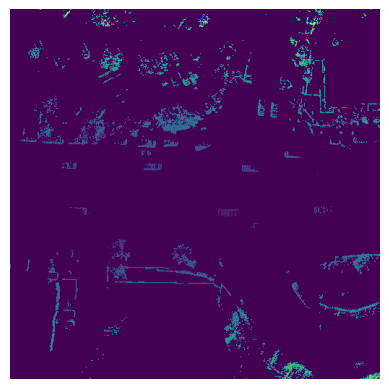

In [32]:
pseudo_img_src_mean = pseudo_img_src.mean(dim=0)
print(pseudo_img_src_mean.shape)
plt.imshow(pseudo_img_src_mean.cpu().numpy())
plt.axis(False)
print(pseudo_img_src_mean.max(), pseudo_img_src_mean.min())

torch.Size([512, 512])
tensor(1.3491, device='cuda:0') tensor(0., device='cuda:0')


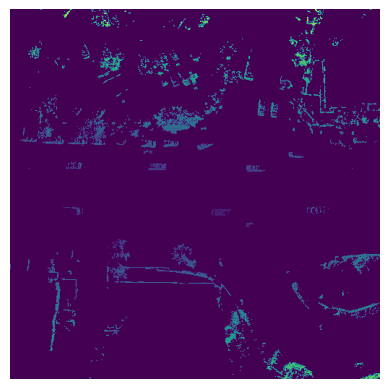

In [33]:
pseudo_img_dst_mean = pseudo_img_dst.mean(dim=0)
print(pseudo_img_dst_mean.shape)
plt.imshow(pseudo_img_dst_mean.cpu().numpy())
plt.axis(False)
print(pseudo_img_dst_mean.max(), pseudo_img_dst_mean.min())

torch.Size([512, 512])
0.3998289
-3.7077937


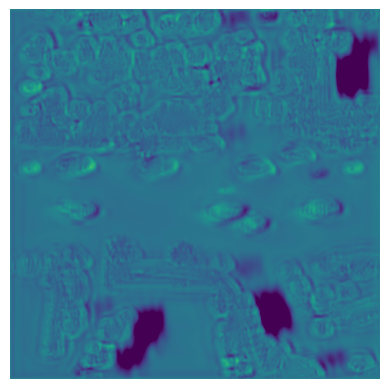

In [46]:
pseudo_img_grid_mean = pseudo_img_grid.mean(dim=0)
print(pseudo_img_grid_mean.shape)
plt.imshow(pseudo_img_grid_mean.cpu().numpy(), vmin=-1, vmax=1)
plt.axis(False)
print(pseudo_img_grid_mean.cpu().numpy().max())
print(pseudo_img_grid_mean.cpu().numpy().min())

torch.Size([512, 512])
0.3998289
-3.7077937


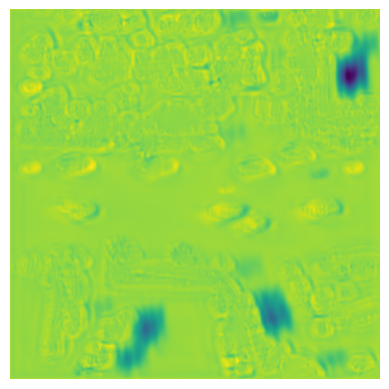

In [36]:
pseudo_img_grid_mean_0 = pseudo_img_grid[:32,...].mean(dim=0)
print(pseudo_img_grid_mean.shape)
plt.imshow(pseudo_img_grid_mean.cpu().numpy())
plt.axis(False)
print(pseudo_img_grid_mean.cpu().numpy().max())
print(pseudo_img_grid_mean.cpu().numpy().min())

torch.Size([512, 512])
0.3998289
-3.7077937


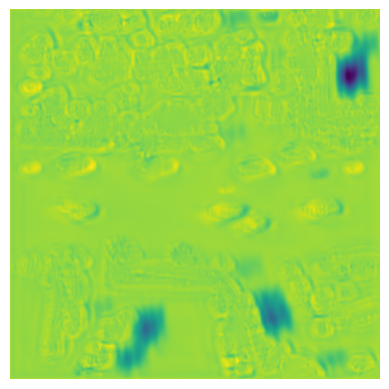

In [37]:
pseudo_img_grid_1 = 
pseudo_img_grid_mean_1 = pseudo_img_grid[32:,...].mean(dim=0)
print(pseudo_img_grid_mean.shape)
plt.imshow(pseudo_img_grid_mean.cpu().numpy())
plt.axis(False)
print(pseudo_img_grid_mean.cpu().numpy().max())
print(pseudo_img_grid_mean.cpu().numpy().min())